# 数据生成代码

## train 训练集

In [1]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt

In [2]:
# 常量设定
hbar = 1.0  # 普朗克常数，或者任何常数
grid_size = (128, 128, 128)  # 网格大小，可以根据需要调整
num_samples = 200  # 数据集样本数量

In [3]:
# 文件路径
output_dir = "data/processed/train"
velocity_dir = os.path.join(output_dir, "velocities")
abcd_dir = os.path.join(output_dir, "abcd")

# 创建文件夹
os.makedirs(velocity_dir, exist_ok=True)
os.makedirs(abcd_dir, exist_ok=True)


In [4]:
def generate_simple_field(size):
    """
    生成一个简单的标量场，使用单一的正弦函数。
    """
    x = np.linspace(0, 2 * np.pi, size[0])
    y = np.linspace(0, 2 * np.pi, size[1])
    z = np.linspace(0, 2 * np.pi, size[2])
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')


    freq = random.uniform(0.5, 2.0)
    phase = random.uniform(0, 2 * np.pi)
    
    field = (np.sin(freq * X + phase) + np.cos(freq * Y + phase)) * np.cos(Y) * np.sin(Z)
    return field


In [5]:
def generate_complex_field(size):
    """
    生成一个复杂的标量场，使用多频率正弦函数叠加和随机噪声。
    """
    x = np.linspace(0, 2 * np.pi, size[0])
    y = np.linspace(0, 2 * np.pi, size[1])
    z = np.linspace(0, 2 * np.pi, size[2])
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    
    # 多频率正弦函数叠加
    field = (np.sin(X) * np.cos(2 * Y) * np.sin(3 * Z) +
             np.sin(2 * X) * np.cos(Y) * np.sin(Z) +
             np.sin(3 * X) * np.cos(Y) * np.sin(2 * Z))
    
    # 添加噪声
    # noise_std = random.uniform(0.05, 0.2)
    # noise = np.random.normal(0, noise_std, size)
    # field += noise
    
    return field

In [6]:
def generate_random_field(size):
    """
    随机生成标量场，简单或复杂版本。
    """
    field = np.zeros(size)
    for _ in range(random.randint(1, 3)):  # 随机选择1到3个场组合
        if random.choice([True, False]):
            field += generate_simple_field(size)
        else:
            field += generate_complex_field(size)
    return field / np.max(np.abs(field))

In [7]:
def compute_gradient(field):
    """
    计算标量场的梯度。
    """
    grad = np.gradient(field)
    return np.array(grad)  # 返回梯度向量场

In [8]:
def generate_sample(hbar, grid_size):
    """
    生成一个样本，包括速度场u和物理量a, b, c, d。
    """
    a = generate_random_field(grid_size)
    b = generate_random_field(grid_size)
    c = generate_random_field(grid_size)
    d = generate_random_field(grid_size)
    
    grad_a = compute_gradient(a)
    grad_b = compute_gradient(b)
    grad_c = compute_gradient(c)
    grad_d = compute_gradient(d)
    
    u = hbar * (a * grad_b - b * grad_a + c * grad_d - d * grad_c)
    
    return u, a, b, c, d


In [9]:
# 生成数据集
for i in range(num_samples):
    u, a, b, c, d = generate_sample(hbar, grid_size)
    
    # 保存速度场
    velocity_path = os.path.join(velocity_dir, f"sample_{i+1}_u.npy")
    np.save(velocity_path, u)
    
    # 保存对应的物理量a, b, c, d
    abcd_path = os.path.join(abcd_dir, f"sample_{i+1}_abcd.npy")
    np.save(abcd_path, np.array([a, b, c, d]))
    
    print(f"Sample {i+1} generated and saved.")

print("Data generation completed.")


Sample 1 generated and saved.
Sample 2 generated and saved.
Sample 3 generated and saved.
Sample 4 generated and saved.
Sample 5 generated and saved.
Sample 6 generated and saved.
Sample 7 generated and saved.
Sample 8 generated and saved.
Sample 9 generated and saved.
Sample 10 generated and saved.
Sample 11 generated and saved.
Sample 12 generated and saved.
Sample 13 generated and saved.
Sample 14 generated and saved.
Sample 15 generated and saved.
Sample 16 generated and saved.
Sample 17 generated and saved.
Sample 18 generated and saved.
Sample 19 generated and saved.
Sample 20 generated and saved.
Sample 21 generated and saved.
Sample 22 generated and saved.
Sample 23 generated and saved.
Sample 24 generated and saved.
Sample 25 generated and saved.
Sample 26 generated and saved.
Sample 27 generated and saved.
Sample 28 generated and saved.
Sample 29 generated and saved.
Sample 30 generated and saved.
Sample 31 generated and saved.
Sample 32 generated and saved.
Sample 33 generat

In [10]:
# 可视化函数
def visualize_npy_files(velocity_file, abcd_file, slice_index=64):
    """
    可视化速度场和物理量的某个二维切片。
    
    :param velocity_file: 速度场的 .npy 文件路径
    :param abcd_file: 物理量 (a, b, c, d) 的 .npy 文件路径
    :param slice_index: 要可视化的切片索引（默认值为 64，适用于 128x128x128 的网格）
    """
    # 读取 .npy 文件
    velocity = np.load(velocity_file)
    abcd = np.load(abcd_file)
    
    # 提取速度场分量
    u_x, u_y, u_z = velocity
    
    # 提取物理量 a, b, c, d
    a, b, c, d = abcd
    
    # 可视化速度场分量的切片
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(u_x[:, :, slice_index], cmap="RdBu_r")
    plt.colorbar()
    plt.title(f"u_x (Slice at Z={slice_index})")
    
    plt.subplot(1, 3, 2)
    plt.imshow(u_y[:, :, slice_index], cmap="RdBu_r")
    plt.colorbar()
    plt.title(f"u_y (Slice at Z={slice_index})")
    
    plt.subplot(1, 3, 3)
    plt.imshow(u_z[:, :, slice_index], cmap="RdBu_r")
    plt.colorbar()
    plt.title(f"u_z (Slice at Z={slice_index})")
    
    plt.show()
    
    # 可视化物理量的切片
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 4, 1)
    plt.imshow(a[:, :, slice_index], cmap="viridis")
    plt.colorbar()
    plt.title(f"Scalar Field a (Slice at Z={slice_index})")
    
    plt.subplot(1, 4, 2)
    plt.imshow(b[:, :, slice_index], cmap="viridis")
    plt.colorbar()
    plt.title(f"Scalar Field b (Slice at Z={slice_index})")
    
    plt.subplot(1, 4, 3)
    plt.imshow(c[:, :, slice_index], cmap="viridis")
    plt.colorbar()
    plt.title(f"Scalar Field c (Slice at Z={slice_index})")
    
    plt.subplot(1, 4, 4)
    plt.imshow(d[:, :, slice_index], cmap="viridis")
    plt.colorbar()
    plt.title(f"Scalar Field d (Slice at Z={slice_index})")
    
    plt.show()


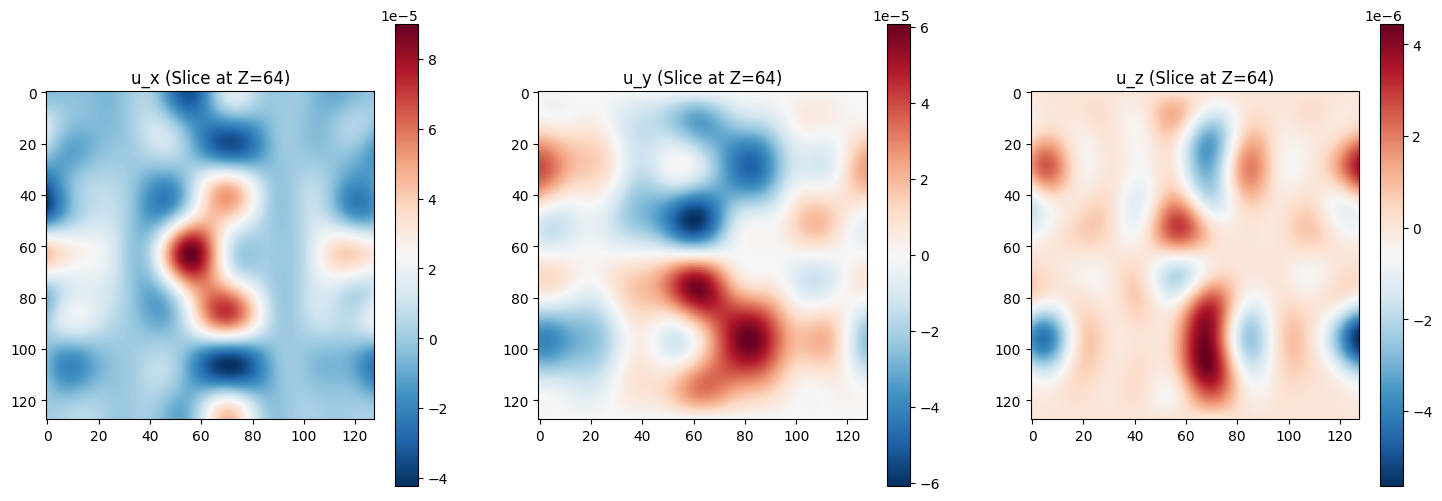

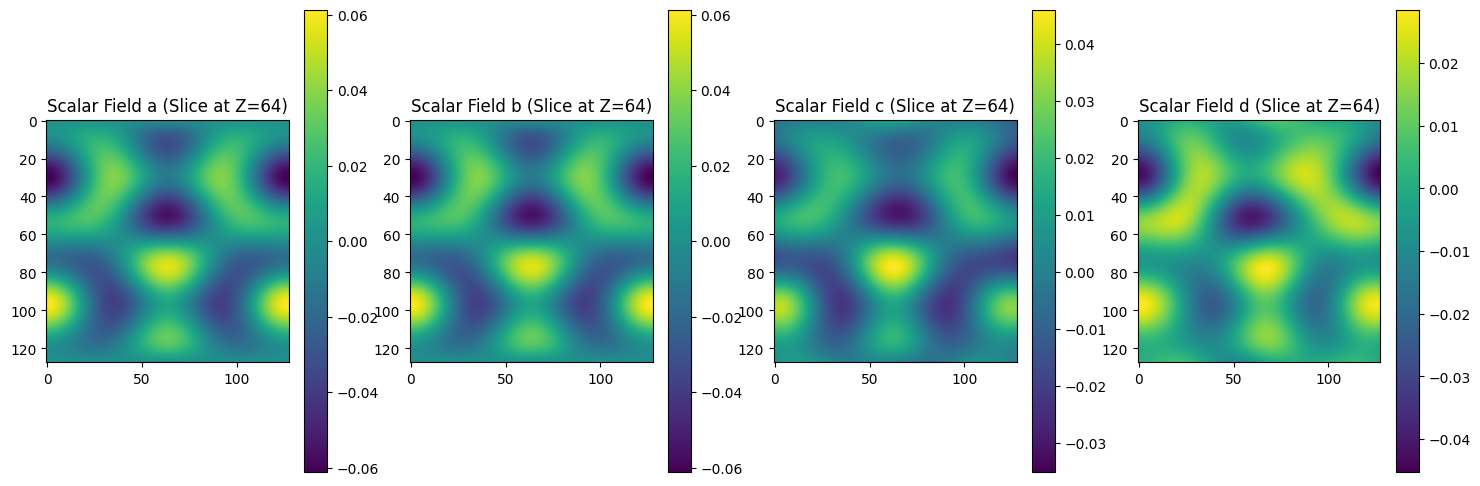

In [11]:
# 示例使用：可视化已生成的样本
velocity_file = 'data/processed/train/velocities/sample_1_u.npy'
abcd_file = 'data/processed/train/abcd/sample_10_abcd.npy'


visualize_npy_files(velocity_file, abcd_file, slice_index=64)

In [12]:
# 调试信息
velocity = np.load(velocity_file)
a = np.load(abcd_file)[0]

print("Max of u_x:", np.max(velocity[0]), "Min of u_x:", np.min(velocity[0]))
print("Max of a:", np.max(a), "Min of a:", np.min(a))

Max of u_x: 0.05782820066815358 Min of u_x: -0.04431756053923242
Max of a: 1.0 Min of a: -1.0


In [13]:
grad_a = compute_gradient(a)
print("Max of grad_a:", np.max(grad_a), "Min of grad_a:", np.min(grad_a))

# 手动计算并检查 u 的值
u_manual, a, b, c, d = generate_sample(hbar, grid_size)
grad_a_manual = compute_gradient(a)
grad_b_manual = compute_gradient(b)
grad_c_manual = compute_gradient(c)
grad_d_manual = compute_gradient(d)

u_check = hbar * (a * grad_b_manual - b * grad_a_manual + c * grad_d_manual - d * grad_c_manual)
print("Max of u_check:", np.max(u_check), "Min of u_check:", np.min(u_check))

Max of grad_a: 0.12310933911526456 Min of grad_a: -0.12310933911526456
Max of u_check: 0.06934414324682053 Min of u_check: -0.058785801157051176


## test 数据集

In [14]:
output_dir_test = "data/processed/test"
velocity_dir_test = os.path.join(output_dir_test, "velocities")
abcd_dir_test = os.path.join(output_dir_test, "abcd")

# 创建测试数据文件夹
os.makedirs(velocity_dir_test, exist_ok=True)
os.makedirs(abcd_dir_test, exist_ok=True)

num_samples_test = 20  # 例如生成20个测试样本

for i in range(num_samples_test):
    u, a, b, c, d = generate_sample(hbar, grid_size)
    
    # 保存测试集速度场
    velocity_path_test = os.path.join(velocity_dir_test, f"sample_{i+1}_u.npy")
    np.save(velocity_path_test, u)
    
    # 保存测试集物理量a, b, c, d
    abcd_path_test = os.path.join(abcd_dir_test, f"sample_{i+1}_abcd.npy")
    np.save(abcd_path_test, np.array([a, b, c, d]))
    
    print(f"Test sample {i+1} generated and saved.")

print("Test data generation completed.")


Test sample 1 generated and saved.
Test sample 2 generated and saved.
Test sample 3 generated and saved.
Test sample 4 generated and saved.
Test sample 5 generated and saved.
Test sample 6 generated and saved.
Test sample 7 generated and saved.
Test sample 8 generated and saved.
Test sample 9 generated and saved.
Test sample 10 generated and saved.
Test sample 11 generated and saved.
Test sample 12 generated and saved.
Test sample 13 generated and saved.
Test sample 14 generated and saved.
Test sample 15 generated and saved.
Test sample 16 generated and saved.
Test sample 17 generated and saved.
Test sample 18 generated and saved.
Test sample 19 generated and saved.
Test sample 20 generated and saved.
Test data generation completed.


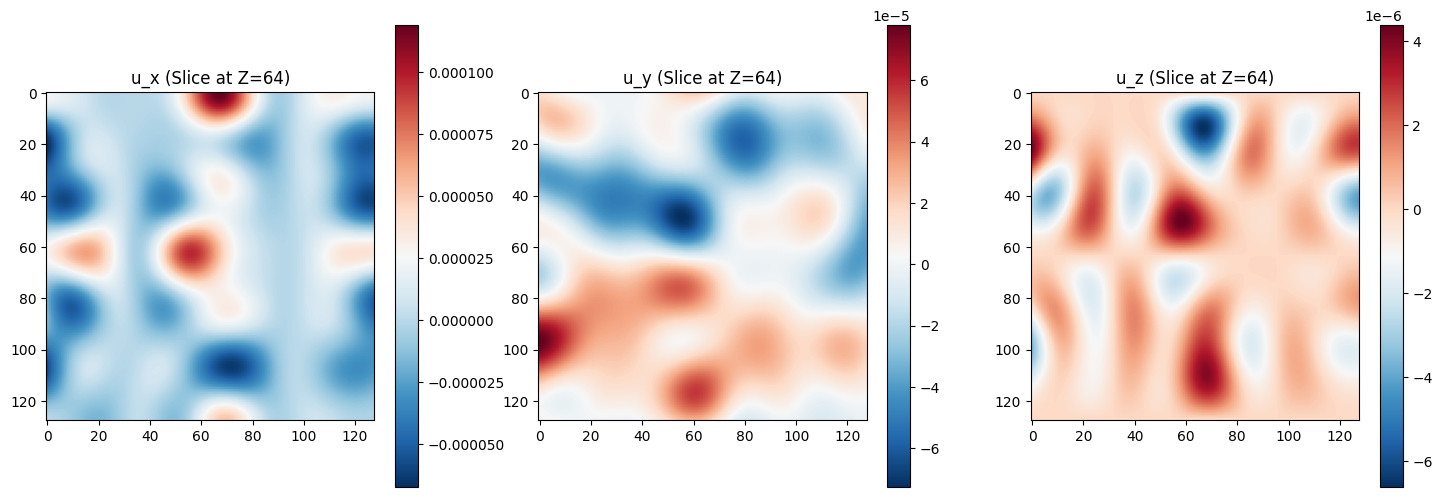

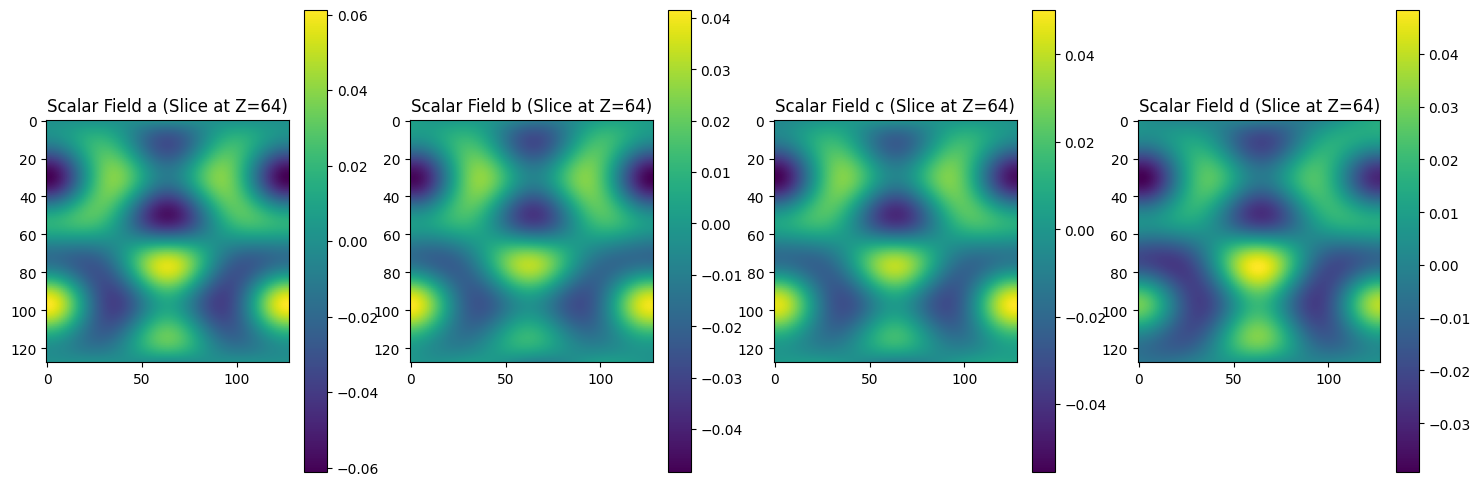

In [15]:
# 示例使用：可视化已生成的样本
velocity_file = 'data/processed/test/velocities/sample_1_u.npy'
abcd_file = 'data/processed/test/abcd/sample_10_abcd.npy'


visualize_npy_files(velocity_file, abcd_file, slice_index=64)

In [ ]:
//TODO:
